## Utility Analysis

[Paper on using this data set for uplift modeling.](https://hal.science/hal-02515860/)

**Overview**

This file contains analysis of the utility of synthetic data sets produced using the optimized bayesian sequential synthesis and the differentially private GAN model.

A potential use case for synthetic data is to synthesize data that would otherwise be too sensitive to share, and allow companies to measure treatment efficacy conditional on those covariates.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from scipy.stats import wasserstein_distance

num_synthetic = 8

***

Import the original and synthesized Criteo data sets.

In [2]:
# import the confidential data
original = pd.read_csv("../../Data/Criteo/cleaned_criteo.gz", 
                       compression='gzip', 
                       sep='\,',
                       header=0,
                       engine='python')

<>:4: SyntaxWarning: invalid escape sequence '\,'
<>:4: SyntaxWarning: invalid escape sequence '\,'
/var/folders/17/_m9r0gbs5y1cgvcmx6mg03n80000gp/T/ipykernel_36820/2598108672.py:4: SyntaxWarning: invalid escape sequence '\,'
  sep='\,',


In [3]:
original

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


***

Fit an overall model for `conversion` on the confidential data.

In [4]:
conversion_model = LogisticRegression(penalty=None)

In [5]:
X = original.drop(['conversion'], axis=1)
y = original.conversion

In [6]:
conversion_model.fit(X, y)

/opt/homebrew/Cellar/jupyterlab/4.4.6/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


These are the coefficients from the original model, including the intercept. We'll treat these as the 'ground truth'.

In [7]:
original_coefs = pd.Series(np.concatenate([conversion_model.intercept_, conversion_model.coef_.flatten()]))
original_coefs

0    -0.172464
1     0.009187
2    -0.689750
3    -0.981666
4    -0.067981
5     0.779434
6    -0.141257
7     0.024174
8    -0.049576
9    -0.620544
10   -0.011615
11    0.115049
12   -0.596792
13   -0.544093
14    6.900471
15    1.302530
dtype: float64

Define a function that takes a data set as input and computes the logistic regression coefficients of interest.

In [8]:
def logistic_coefs(dataset):
    # define logistic regression model
    conversion_model = LogisticRegression(penalty=None, max_iter=1000)
    # create covariates data
    X = dataset.drop(['conversion'], axis=1)
    # create outcome (target) variable
    y = dataset.conversion
    # fit model
    conversion_model.fit(X, y)
    # store coefficients
    current_coefs = pd.Series(np.concatenate([conversion_model.intercept_, conversion_model.coef_.flatten()]))
    return current_coefs

Loop over optimized synthetic data sets and compute logistic regression coefficients.

In [9]:
opt_syn_coefs = pd.DataFrame()

for i in range(num_synthetic):
    # import an optimized synthetic data set
    opt_syn_temp = pd.read_csv("../../Data/Criteo/cart_" + str(i) + "_full.csv")
    opt_syn_temp = opt_syn_temp[original.columns]
    current_coefs = logistic_coefs(opt_syn_temp)
    opt_syn_coefs = pd.concat([opt_syn_coefs, current_coefs], axis=1)
    print("Coefficients for data set " + str(i) + " computed.")

Coefficients for data set 0 computed.
Coefficients for data set 1 computed.
Coefficients for data set 2 computed.
Coefficients for data set 3 computed.
Coefficients for data set 4 computed.
Coefficients for data set 5 computed.
Coefficients for data set 6 computed.
Coefficients for data set 7 computed.


In [11]:
coef_names = pd.Series(["intercept"])
coef_names = pd.concat([coef_names, pd.Series(X.columns)], axis=0)
opt_syn_coefs.index = coef_names
opt_syn_coefs.columns = np.arange(num_synthetic)

Plot the distributions of regression coefficients for each method relative to the ground truth - the coefficient estimates from the original data.

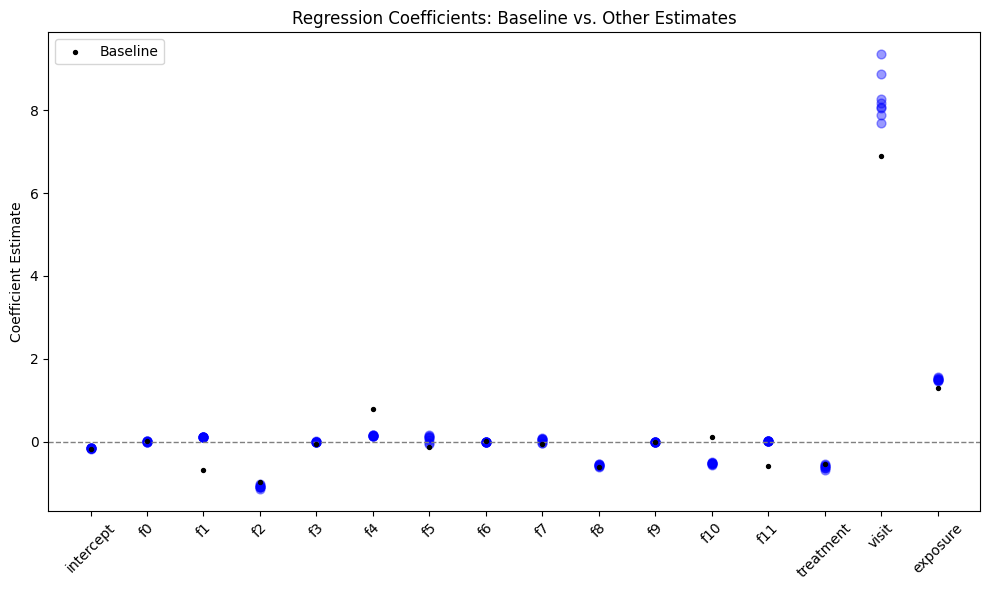

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(original_coefs))

# Baseline (black dots)
ax.scatter(x, original_coefs.values, color="black", s=num_synthetic, zorder=3, label="Baseline")

# Other estimates (blue dots, semi-transparent)
for col in opt_syn_coefs.columns:
    ax.scatter(x, opt_syn_coefs[col].values, color="blue", alpha=0.4, s=40)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(opt_syn_coefs.index, rotation=45)
ax.axhline(0, color="gray", linewidth=1, linestyle="--")
ax.set_ylabel("Coefficient Estimate")
ax.legend()
ax.set_title("Regression Coefficients: Baseline vs. Other Estimates")

plt.tight_layout()
plt.show()

Fit a model on the `treatment = 0` and `treatment = 1` subsets. Compute the uplift for each observation.

Diemert et al. (2018) published a paper alongside the Criteo uplift data. They discuss a two-model approach to modeling uplift, which we utilize here for one example of a use case for synthetic data.

Tasks for Ethan:

- compute uplift for observations in the original and synthetic data sets (use the two-model approach from Diemert et al. (2020))
- compare uplift distributions from the synthetic data sets to uplift distribution from the original data using
    - Wasserstein or some other distributional distance/similarity metric
    - Mean uplift
    - std. deviation uplift
    - read up on the *area under the uplift curve* (AUUC) metric from Diemert et al. (2020). Compute the AUUC for a model trained and evaluated on the original data. Compare that to AUUC values for models trained on each synthetic data set, and evaluated on the original data.

Once this workflow is established, we can repeat it for a train/test data split. We'll train the uplift models on the original/synthetic training data, and evaluate their performance using the above metrics computed on uplift distributions from the test data.


Compute Uplift

In [13]:
def compute_uplift_distribution(df, feature_cols = [f"f{i}" for i in range(12)], treatment_col="treatment", outcome_col="conversion"):
    treat_df   = df[df[treatment_col] == 1]
    control_df = df[df[treatment_col] == 0]
    X_treat   = treat_df[feature_cols]
    y_treat   = treat_df[outcome_col]
    X_control = control_df[feature_cols]
    y_control = control_df[outcome_col]

    model_t = LogisticRegression(max_iter=200)
    model_c = LogisticRegression(max_iter=200)
    model_t.fit(X_treat, y_treat)
    model_c.fit(X_control, y_control)

    X_all = df[feature_cols]
    p_t = model_t.predict_proba(X_all)[:, 1]
    p_c = model_c.predict_proba(X_all)[:, 1]

    uplift = p_t - p_c
    return uplift

In [14]:
uplift_original = compute_uplift_distribution(original)

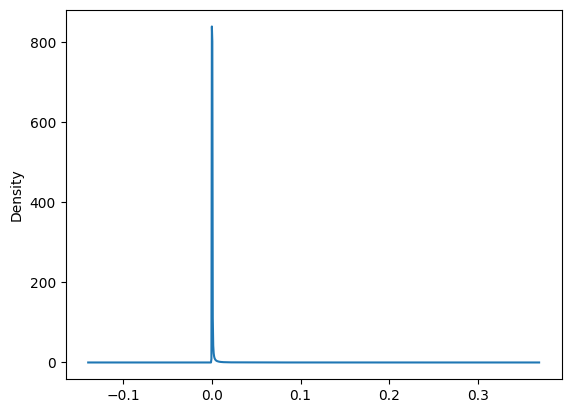

In [15]:
s = pd.Series(uplift_original)
ax = s.plot.kde()

In [16]:
uplift_distributions = pd.DataFrame()
feature_cols = [c for c in original.columns if c not in ["treatment", "conversion"]]
uplift_distributions["original"] = uplift_original
for i in range(num_synthetic):
    syn_df = pd.read_csv("../../Data/Criteo/cart_" + str(i) + "_full.csv")
    # Column alignment
    syn_df = syn_df[original.columns]
    uplift_vals = compute_uplift_distribution(
        syn_df
    )
    uplift_distributions[f"uplift_{i}"] = uplift_vals
    print(f"Uplift distribution computed for dataset {i}.")

Uplift distribution computed for dataset 0.
Uplift distribution computed for dataset 1.
Uplift distribution computed for dataset 2.
Uplift distribution computed for dataset 3.
Uplift distribution computed for dataset 4.
Uplift distribution computed for dataset 5.
Uplift distribution computed for dataset 6.
Uplift distribution computed for dataset 7.


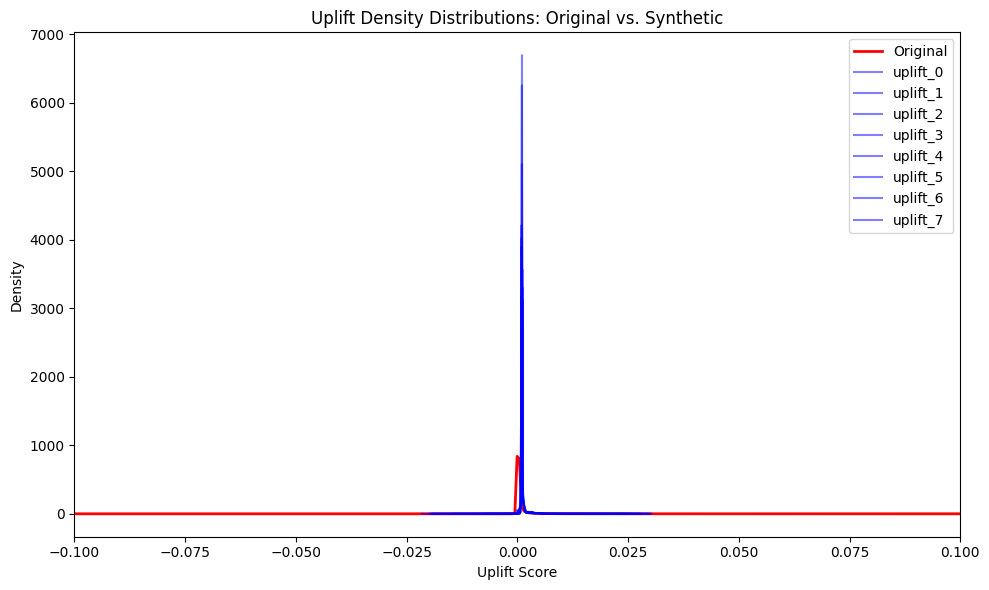

In [17]:
plt.figure(figsize=(10, 6))

pd.Series(uplift_distributions["original"]).plot.kde(
    color="red", linewidth=2, label="Original"
)

for col in uplift_distributions.columns:
    if col == "original":
        continue
    pd.Series(uplift_distributions[col]).plot.kde(
        color="blue", alpha=0.5, linewidth=1.5, label=col
    )

plt.title("Uplift Density Distributions: Original vs. Synthetic")
plt.xlabel("Uplift Score")
plt.ylabel("Density")
plt.xlim(-0.1, 0.1)
plt.legend()
plt.tight_layout()
plt.show()

Compare Distributions: Mean and SD

In [18]:
uplift_distributions.mean()

original    0.000965
uplift_0    0.001138
uplift_1    0.001141
uplift_2    0.001197
uplift_3    0.001172
uplift_4    0.001156
uplift_5    0.001190
uplift_6    0.001174
uplift_7    0.001185
dtype: float64

In [19]:
uplift_distributions.std()

original    0.005958
uplift_0    0.000642
uplift_1    0.000590
uplift_2    0.000678
uplift_3    0.000654
uplift_4    0.000666
uplift_5    0.000744
uplift_6    0.000681
uplift_7    0.000672
dtype: float64

Compare Distributions: Wasserstein

In [20]:
cols = uplift_distributions.columns
n = len(cols)
wasserstein_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        wasserstein_matrix[i, j] = wasserstein_distance(uplift_distributions[cols[i]], uplift_distributions[cols[j]])

wasserstein_df = pd.DataFrame(wasserstein_matrix, index=cols, columns=cols)
print(wasserstein_df)

          original  uplift_0  uplift_1  uplift_2  uplift_3  uplift_4  \
original  0.000000  0.001198  0.001194  0.001236  0.001192  0.001198   
uplift_0  0.001198  0.000000  0.000041  0.000075  0.000059  0.000057   
uplift_1  0.001194  0.000041  0.000000  0.000092  0.000063  0.000059   
uplift_2  0.001236  0.000075  0.000092  0.000000  0.000093  0.000056   
uplift_3  0.001192  0.000059  0.000063  0.000093  0.000000  0.000084   
uplift_4  0.001198  0.000057  0.000059  0.000056  0.000084  0.000000   
uplift_5  0.001188  0.000087  0.000088  0.000074  0.000096  0.000047   
uplift_6  0.001213  0.000043  0.000072  0.000056  0.000055  0.000073   
uplift_7  0.001223  0.000057  0.000087  0.000066  0.000053  0.000081   

          uplift_5  uplift_6  uplift_7  
original  0.001188  0.001213  0.001223  
uplift_0  0.000087  0.000043  0.000057  
uplift_1  0.000088  0.000072  0.000087  
uplift_2  0.000074  0.000056  0.000066  
uplift_3  0.000096  0.000055  0.000053  
uplift_4  0.000047  0.000073  0.0

**Note that the columns of the synthetic data sets need to be reordered after you import the data so that the order matches that of the original data**.

Real-world use cases driving these analyses?

In-sample measurements: if an advertising company or walled garden were to share the data from a past campaign, could a user obtain reasonable estimates of the uplift from the synthetic data?

Out-of-sample measurements: given the results of a previous campaign, can a model trained on the synthetic data that can give reasonably accurate estimates for uplift for *real* out-of-sample consumers?